# **IAA - PRÀCTICA: MAIN**

### **Instal·lar llibreries necessàries**

In [ ]:
%pip install -r ../assets/requirements.txt 

### **Importar llibreries**

In [1]:
def import_dependencies():
	global pd, np, plt, sns, skl

	import pandas as pd
	import numpy as np
	import matplotlib.pyplot as plt
	import seaborn as sns
	import sklearn as skl

import_dependencies()

### **Llegir les dades (Cirrhosis Dataset)**

In [2]:
def load_dataset(save_to_csv: bool = True):
	global data
	from ucimlrepo import fetch_ucirepo 
	
	# Fetch dataset
	cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878)

	data = pd.DataFrame(cirrhosis_patient_survival_prediction.data.original)

	if save_to_csv:
		# Guardem el dataset per poder-lo visualitzar sencer
		data.to_csv('../assets/data/raw_cirrhosis.csv', index=False)

#load_dataset(save_to_csv=True)

### **Informació del dataset inicial**

In [ ]:
data.shape

In [ ]:
data.head(-10)

In [ ]:
data.info()

### **Preprocessing inicial**

In [3]:
def initial_preprocessing(data: pd.DataFrame, save_to_csv: bool = True):
	"""
	Reemplaça els valors 'NaNN' per NaN, assigna els tipus de dades correctes a cada columna i renombra les classes d'algunes variables per una millor comprensió.
	"""
	# Reemplaçar l'string 'NaNN' per NaN
	data.replace(to_replace=['NaNN', '', pd.NA], value=np.nan, inplace=True)

	# Assignem els tipus de dades correctes a cada columna
	int64_variables = ['N_Days', 'Age', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
	float64_variables = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Prothrombin']
	category_variables = ['ID', 'Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
	boolean_variables = ['Ascites', 'Hepatomegaly', 'Spiders']

	data[int64_variables] = data[int64_variables].astype('Int64')
	data[float64_variables] = data[float64_variables].astype('float64')
	data[category_variables] = data[category_variables].astype('category')

	global original_column_types

	original_column_types = {col: str(data[col].dtype) for col in data.columns} # Guardem els tipus de dades de cada columna

	# Renombrem les classes d'algunes variables per una millor comprensió
	data['Status'] = data['Status'].replace({'D': 'Dead', 'C': 'Alive', 'CL': 'LiverTransplant'})
	data[boolean_variables] = data[boolean_variables].replace({'Y': 1, 'N': 0})
	data['Edema'] = data['Edema'].replace({'N': 'NoEdema', 'S': 'EdemaResolved', 'Y': 'EdemaPersistent'})

	global original_categorical_categories
	original_categorical_categories = {col: data[col].unique() for col in data.select_dtypes(include='category').columns.drop('ID')} # Guardem les categories originals de les variables categòriques

	if save_to_csv:
		# Guardem el dataset
		data.to_csv('../assets/data/initial_preprocessing_cirrhosis.csv', index=False)

#initial_preprocessing(data=data, save_to_csv=True)

In [ ]:
data.head(-10)

In [ ]:
data.info()

### **Anàlisis inicial de les variables**

In [ ]:
data.head(-10)

In [ ]:
data.isna().sum().sort_values(ascending=False)

In [ ]:
# Estudi de les variables numèriques
data.describe()

In [ ]:
# Estadístiques de les variables categòriques
data.describe(include='category')

In [ ]:
def numerical_vars_histograms(data: pd.DataFrame):
    # Visualització de les distribucions de les variables numèriques en una sola figura
    numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

    num_rows = int(np.ceil(len(numerical_columns) / 2))

    fig = plt.figure(figsize=(10, num_rows * 4))

    for i, col in enumerate(numerical_columns):
        ax = fig.add_subplot(num_rows, 2, i + 1)
        
        sns.histplot(data[col], edgecolor="k", linewidth=1.5, kde=True)
        
        plt.xticks(rotation=45, ha='right')
        
        ax.set_title(f'Distribució de la variable numèrica {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Freqüència')

    plt.tight_layout()
    plt.show()

#numerical_vars_histograms(data=data)

In [ ]:
def categorical_vars_countplots(data: pd.DataFrame):
    """
    Visualització de les distribucions de les variables categòriques en una sola figura (menys ID).
    """
    # Visualització de les distribucions de les variables categòriques en una sola figura (menys ID)
    categorical_columns = data.select_dtypes(include=['category']).columns.drop(['ID'])
    num_rows = int(np.ceil(len(categorical_columns) / 2))

    fig = plt.figure(figsize=(10, num_rows * 4))

    for i, col in enumerate(categorical_columns):
        ax = fig.add_subplot(num_rows, 2, i + 1)
        
        sns.countplot(data=data, x=col, ax=ax, hue=col, legend=False)
        
        plt.xticks(rotation=45, ha='right')
        
        ax.set_title(f'Distribució de la variable categòrica {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Quantitat')

    plt.tight_layout()
    plt.show()

#categorical_vars_countplots(data=data)

### **Tractament d'outliers**

In [ ]:
def compare_iqr_factors(data: pd.DataFrame, factors: list = [1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]):
	"""
	Compara diferents factors que multipliquen al IQR per a determinar els outliers i realitza un gràfic evolutiu per comparar-los.
	"""
	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

	plt.figure(figsize=(10, 6))

	# Dictionary to store outlier percentages for each factor and column
	outlier_percentages = {col: [] for col in numerical_columns}
	total_percentages = [set() for _ in range(len(factors))]

	for col in numerical_columns:
		Q1 = data[col].quantile(0.25)
		Q3 = data[col].quantile(0.75)
		IQR = Q3 - Q1

		for f_id, factor in enumerate(factors):
			outliers_mask = ((data[col] < (Q1 - factor * IQR)) | (data[col] > (Q3 + factor * IQR)))
			total_percentages[f_id].update(data.index[outliers_mask])
			outliers_percentage = np.mean(outliers_mask) * 100
			outlier_percentages[col].append(outliers_percentage)

	total_percentages = [(len(outliers) / len(data)) * 100 for outliers in total_percentages]
			
	# Plotting the results
	for col, percentages in outlier_percentages.items():
		plt.plot(factors, percentages, label=col)
	plt.plot(factors, total_percentages, label='Total', linestyle='--', color='black')

	plt.xlabel('Factor multiplicatiu del IQR')
	plt.ylabel('Percentage d\'outliers (%)')
	plt.title('Percentatge d\'outliers de cada variable numèrica per a diferents factors multiplicatius del IQR')
	plt.xticks(factors)
	
	plt.legend()
	plt.grid(True)
	plt.show()

#compare_iqr_factors(data=data, factors=[1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5])

In [4]:
def delete_outliers(data: pd.DataFrame, factor: float = 1.5, plots: bool = True, save_to_csv: bool = True):
    """
    Funció que detecta, visualitza i elimina els outliers d'un dataset. El factor multiplica el IQR per a determinar quins valors són outliers.
    """
    # Detecció, visualització i eliminació d'outliers
    numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

    outliers_indices = []

    for col in numerical_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers_mask = ((data[col] < lower_bound) | (data[col] > upper_bound))
        outliers = data[col][outliers_mask]
        non_outliers = data[col][~outliers_mask]

        outliers_indices.extend(data[col][outliers_mask].index.tolist())
        
        if plots:
            fig, axes = plt.subplots(2, 2, figsize=(8, 6))

            # Boxplot con los outliers originales
            sns.boxplot(ax=axes[0, 0], y=data[col], orient='v')
            axes[0, 0].scatter(x=[0]*len(outliers), y=outliers, color='red', marker='o')
            axes[0, 0].set_title(f'Boxplot de {col} con outliers ({factor}x IQR)')

            # Histograma con línea vertical para outliers
            sns.histplot(ax=axes[0, 1], data=data, x=col, kde=True)
            if (data[col] < lower_bound).any():
                axes[0, 1].axvline(x=lower_bound, color='red', linestyle='dashed')
            if (data[col] > upper_bound).any():
                axes[0, 1].axvline(x=upper_bound, color='red', linestyle='dashed')
            axes[0, 1].set_title(f'Histograma de {col}')
            axes[0, 1].set_xlabel(col)
            axes[0, 1].set_ylabel('Frecuencia')

            # Boxplot sin los outliers
            sns.boxplot(ax=axes[1, 0], y=non_outliers, orient='v')
            axes[1, 0].set_title(f'Boxplot de {col} sin outliers')

            # Histograma sin los outliers
            sns.histplot(ax=axes[1, 1], data=data[~outliers_mask], x=col, kde=True)
            axes[1, 1].set_title(f'Histograma de {col} sin outliers')

            percent_outliers = len(outliers) / data.shape[0] * 100
            fig.text(x=0.5, y=0, s=f'Outliers de {col} ({factor}x IQR): {len(outliers)} ({percent_outliers:.2f}%)', 
                    ha='center', va='center')

            plt.tight_layout()
            plt.show()


    unique_outliers = len(set(outliers_indices))

    print(f"Datset amb outliers: {data.shape[0]} files i {data.shape[1]} columnes.")
    print(f"Nombre total d'outliers únics eliminats: {unique_outliers} ({unique_outliers / data.shape[0] * 100:.2f}% de tot el dataset).")

    # Eliminació d'outliers
    data.drop(list(set(outliers_indices)), inplace=True)
    
    print(f"Dataset sense outliers: {data.shape[0]} files i {data.shape[1]} columnes.")

    if save_to_csv:
        # Guardem el dataset
        data.to_csv('../assets/data/no_outliers_cirrhosis.csv', index=False)

#delete_outliers(data=data, factor=3, plots=False, save_to_csv=True)

### **Funció per tractar les últimes files del dataset (amb molts missings)**

In [ ]:
def delete_last_rows(data: pd.DataFrame, save_to_csv: bool = True):
	"""
	Elimina les últimes files del dataset (les que contenen 9 NaNs).
	"""
	# Eliminem les últimes files del dataset (les que contenen 9 NaNs)
	data.drop(data[data.isna().sum(axis=1) == 9].index, inplace=True)

	if save_to_csv:
		# Guardem el dataset
		data.to_csv('../assets/data/last_rows_deleted_cirrhosis.csv', index=False)

#delete_last_rows(data=data, save_to_csv=True)

### **Recodificació de variables categòriques**

In [ ]:
def encode_variables(data: pd.DataFrame, save_to_csv: bool = True):
    """
    Codifica les variables categòriques que calgui per a poder-les utilitzar en els models de ML. 
    A més, guarda el mapping per a poder decodificar-les.
    Els NaNs es mantenen (en comptes de considerar-los una classe més) per poder imputar-los posteriorment.
    """
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.impute import SimpleImputer

    global ohe_mapping, original_columns_order

    original_columns_order = data.columns

    columns_to_encode = ['Drug', 'Sex', 'Edema', 'Stage'] # Sense la variable 'Status' perquè és la target i, a més, no té valors NaN

    na_indexs_per_old_encoded_column = {col: set(data[data[col].isna()].index) for col in columns_to_encode} # Guardem els indexs dels NaNs per a cada columna a codificar
    new_encoded_columns_per_old_encoded_column = {col: set() for col in columns_to_encode} # Guardem les classes de cada columna a codificar

    # Imputem els NaNs per evitar que es crein columnes innecessàries al fer el OneHotEncoding. Després tornarem a inserir els NaNs
    data[columns_to_encode] = SimpleImputer(strategy='most_frequent').fit_transform(data[columns_to_encode])

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    data_encoded = ohe.fit_transform(data[columns_to_encode])
    encoded_columns = ohe.get_feature_names_out(columns_to_encode)

    # Guardem el mapping per a poder decodificar les variables
    ohe_mapping = {}
    for i, col in enumerate(columns_to_encode):
        # for category in original_categorical_categories[col]:
        #     new_encoded_column_name = f"{col}_{category}"
        #     ohe_mapping[new_encoded_column_name] = (col, category)
        #     new_encoded_columns_per_old_encoded_column[col].add(new_encoded_column_name)

        for category in ohe.categories_[i]:
            new_encoded_column_name = f"{col}_{category}"
            ohe_mapping[new_encoded_column_name] = (col, category)
            new_encoded_columns_per_old_encoded_column[col].add(new_encoded_column_name)

    data[encoded_columns] = data_encoded
    data[encoded_columns] = data[encoded_columns].astype('category')

    # Tornem a posar els NaNs per poder imputar-los
    for col in columns_to_encode:
        for na_index in na_indexs_per_old_encoded_column[col]:
            for new_column in new_encoded_columns_per_old_encoded_column[col]:
                data.loc[na_index, new_column] = np.nan

    # Eliminem les columnes originals
    data.drop(columns=columns_to_encode, inplace=True)

    if save_to_csv:
        # Guardem el dataset
        data.to_csv('../assets/data/encoded_cirrhosis.csv', index=False)

#encode_variables(data=data, save_to_csv=True)

In [ ]:
def decode_variables(data: pd.DataFrame, ohe_mapping, original_columns_order):
    """
    Decodifica les variables categòriques que s'hagin codificat anteriorment.
    """
    reconstructed_columns = {}

    # Creem les columnes reconstruïdes
    for encoded_column in ohe_mapping:
        if encoded_column in data.columns:
            original_column, category = ohe_mapping[encoded_column]

            if original_column not in reconstructed_columns:
                reconstructed_columns[original_column] = pd.Series([np.nan] * len(data), index=data.index, dtype='object')

            category_rows = data[encoded_column] == 1
            reconstructed_columns[original_column].loc[category_rows] = category

    # Eliminem les columnes codificades
    data.drop(columns=[col for col in ohe_mapping if col in data.columns], inplace=True)

    # Inserim les columnes reconstruïdes al DataFrame
    for col in reconstructed_columns:
        data[col] = reconstructed_columns[col]
        data[col] = data[col].astype(original_column_types[col])

    # Reordenem les columnes perquè quedin igual que a l'original
    data = data.reindex(columns=original_columns_order)

#decode_variables(data=data, ohe_mapping=ohe_mapping, original_columns_order=original_columns_order)

### **Partició del dataset en train/test**

In [5]:
def split_dataset(data: pd.DataFrame, test_size: float = 0.15, stratify: bool = True, random_state: int = 42):
	"""
	Particiona el dataset en conjunts de entrenament i prova.
	Assegura que tant el conjunt d'entrenament com el de prova continguin almenys un exemple de cada classe
	de les variables categòriques (excepte 'ID') per evitar problemes en cas que es faci encoding.
	"""
	global train, test, X_train, y_train, X_test, y_test
	
	from sklearn.model_selection import train_test_split

	# Particionem el dataset en conjunts de entrenament i prova
	if stratify:
		train, test = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['Status'])
	else:
		train, test = train_test_split(data, test_size=test_size, random_state=random_state)

	# 'Status' es la variable target
	X_train = train.drop(columns=['Status'])
	y_train = train['Status']
	X_test = test.drop(columns=['Status'])
	y_test = test['Status']

	print(f"Train shape: {train.shape}")
	print(f"Test shape: {test.shape}")

#split_dataset(data=data, test_size=0.15, random_state=42)

### **Escalar variables numèriques**

In [6]:
def scale_variables(data: pd.DataFrame, scaler: str = 'standard', save_to_csv: bool = True):
	assert scaler in ['standard', 'minmax'], "El paràmetre 'scaler' ha de ser 'standard' o 'minmax'."
	"""
	Escala les variables numèriques.
	"""
	from sklearn.preprocessing import StandardScaler, MinMaxScaler

	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

	sc = StandardScaler() if scaler == 'standard' else MinMaxScaler()

	data[numerical_columns] = sc.fit_transform(data[numerical_columns])

	if save_to_csv:
		# Guardem el dataset
		data.to_csv('../assets/data/scaled_cirrhosis.csv', index=False)

# scale_variables(data=data, scaler='standard', save_to_csv=True)
# scale_variables(data=data, scaler='minmax', save_to_csv=True)

### **Imputar els valors faltants (Missings)**

In [ ]:
# Imprimeix les variables que tenen valors NaN, el seu percentatge i el seu tipus de dades
for col_train in train.columns:
	if train[col_train].isna().any():
		print(f"{col_train}: {train[col_train].isna().sum()} NaNs ({train[col_train].isna().sum() / len(train) * 100:.2f}%) ({train[col_train].dtype})")

In [74]:
def find_best_imputer(
                X_train: pd.DataFrame, \
                n_splits: int = 5, \
                random_state: int = 42, \
                print_scores: bool = True, \
                name_num_metric: str = 'r2', \
                name_cat_metric: str = 'accuracy'):
    """
    Prova diferents imputadors, imprimeix els seus resultats i retorna el millor.
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
    from sklearn.impute import KNNImputer, SimpleImputer
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LinearRegression
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    assert n_splits > 1, "El paràmetre 'n_splits' ha de ser major que 1."

    categorical_binary_columns = ['Ascites', 'Hepatomegaly', 'Spiders']
    
    # Definir mètriques
    f1_micro = lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro')
    f1_macro = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
    f1_weighted = lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
    precision_micro = lambda y_true, y_pred: precision_score(y_true, y_pred, average='micro')
    precision_macro = lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro')
    precision_weighted = lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted')
    recall_micro = lambda y_true, y_pred: recall_score(y_true, y_pred, average='micro')
    recall_macro = lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
    recall_weighted = lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')

    fi_binary = lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary')
    precision_binary = lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary')
    recall_binary = lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')

    # Mapeig de les mètriques
    metric_functions = {
        'numerical': {
            'r2': r2_score, \
            'mse': mean_squared_error, \
            'mae': mean_absolute_error, \
            'mape': mean_absolute_percentage_error
        },
        'categorical': {
            'accuracy': accuracy_score, \
            'f1-micro': f1_micro, \
            'f1-macro': f1_macro, \
            'f1-weighted': f1_weighted, \
            'precision-micro': precision_micro, \
            'precision-macro': precision_macro, \
            'precision-weighted': precision_weighted, \
            'recall-micro': recall_micro, \
            'recall-macro': recall_macro, \
            'recall-weighted': recall_weighted
        }                
    }

    binary_categorical_functions_mapping= {
        'f1-micro': fi_binary, \
        'f1-macro': fi_binary, \
        'f1-weighted': fi_binary, \
        'precision-micro': precision_binary, \
        'precision-macro': precision_binary, \
        'precision-weighted': precision_binary, \
        'recall-micro': recall_binary, \
        'recall-macro': recall_binary, \
        'recall-weighted': recall_binary
    }

    assert name_num_metric in metric_functions['numerical'].keys(), f"El paràmetre 'name_num_metric' ha de ser una de les següents mètriques: {metric_functions['numerical'].keys()}"
    assert name_cat_metric in metric_functions['categorical'].keys(), f"El paràmetre 'name_cat_metric' ha de ser una de les següents mètriques: {metric_functions['categorical'].keys()}"

    num_metric = metric_functions['numerical'][name_num_metric]
    cat_metric = metric_functions['categorical'][name_cat_metric]

    # Definir les particions per a la validació creuada
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    # Inicialización de imputadores
    global imputers
    
    imputers = {
        'numerical': 
            {
            'KNNImputer-1': KNNImputer(n_neighbors=1),
            'KNNImputer-2': KNNImputer(n_neighbors=2),
            'KNNImputer-3': KNNImputer(n_neighbors=3),
            'KNNImputer-5': KNNImputer(n_neighbors=5),
            'KNNImputer-10': KNNImputer(n_neighbors=10),
            'KNNImputer-15': KNNImputer(n_neighbors=11),
            'KNNImputer-20': KNNImputer(n_neighbors=12),
            'KNNImputer-25': KNNImputer(n_neighbors=13),
            'KNNImputer-50': KNNImputer(n_neighbors=14),
            'SimpleImputer-mean': SimpleImputer(strategy='mean'),
            'IterativeImputer-lr': IterativeImputer(estimator=LinearRegression(fit_intercept=True), random_state=random_state),
        },

        'categorical': 
            {
            'KNeighborsClassifier-1': KNeighborsClassifier(n_neighbors=1),
            'KNeighborsClassifier-2': KNeighborsClassifier(n_neighbors=2),
            'KNeighborsClassifier-3': KNeighborsClassifier(n_neighbors=3),
            'KNeighborsClassifier-5': KNeighborsClassifier(n_neighbors=5),
            'KNeighborsClassifier-10': KNeighborsClassifier(n_neighbors=10),
            'KNeighborsClassifier-15': KNeighborsClassifier(n_neighbors=15),
            'KNeighborsClassifier-20': KNeighborsClassifier(n_neighbors=20),
            'KNeighborsClassifier-25': KNeighborsClassifier(n_neighbors=25),
            'KNeighborsClassifier-50': KNeighborsClassifier(n_neighbors=50),
            'DecisionTreeClassifier-gini': DecisionTreeClassifier(criterion='gini', random_state=random_state),
            'DecisionTreeClassifier-entropy': DecisionTreeClassifier(criterion='entropy', random_state=random_state), 
            'RandomForestClassifier-gini': RandomForestClassifier(criterion='gini', random_state=random_state),
            'RandomForestClassifier-entropy': RandomForestClassifier(criterion='entropy', random_state=random_state),
        }
    }

    # Inicialització dels resultats
    scores = {'numerical': {name_num_imputer: [] for name_num_imputer in imputers['numerical'].keys()},
              'categorical': {name_cat_imputer: [] for name_cat_imputer in imputers['categorical'].keys()}}
    
    # Treiem les files amb NaNs
    X_train_complete = X_train.dropna().drop(columns=['ID'])

    numerical_columns = X_train_complete.select_dtypes(include=['Int64', 'float64']).columns
    categorical_columns = X_train_complete.select_dtypes(include=['category']).columns

    for train_index, test_index in kf.split(X_train_complete):
        X_train_fold, X_test_fold = X_train_complete.iloc[train_index], X_train_complete.iloc[test_index]

        # Imputació i evaluació per a numèriques
        for name, imputer in imputers['numerical'].items():
            # Introdir artificalment NaNs
            X_test_fold_num_with_nan = X_test_fold.copy()
            for index in X_test_fold.index:
                # Seleccionar aleatoriament una columna numèrica i una categòrica
                np.random.seed(random_state)
                num_col = np.random.choice(numerical_columns)
                X_test_fold_num_with_nan.loc[index, num_col] = np.nan # Només NaNs en les columnes numèriques

            imputer.fit(X_train_fold[numerical_columns])
            X_test_num_imputed = imputer.transform(X_test_fold_num_with_nan[numerical_columns])
            X_test_num_imputed = pd.DataFrame(X_test_num_imputed, columns=numerical_columns, index=X_test_fold_num_with_nan.index)

            num_cols_scores = []
            for col in numerical_columns:
                if X_test_fold_num_with_nan[col].isna().any():
                    # Només evaluar les columnes amb NaNs
                    true_values = X_test_fold[col]
                    imputed_values = X_test_num_imputed[col]
                    score = num_metric(true_values, imputed_values)
                    num_cols_scores.append(score)
                
            scores['numerical'][name].append(np.mean(num_cols_scores))
                
        # Imputació i evaluació per a categòriques
        for name, imputer in imputers['categorical'].items():
            # Introdir artificalment NaNs
            X_test_fold_cat_with_nan = X_test_fold.copy()
            for index in X_test_fold.index:
                # Seleccionar aleatoriament una columna numèrica i una categòrica
                np.random.seed(random_state)
                cat_col = np.random.choice(categorical_columns)
                X_test_fold_cat_with_nan.loc[index, cat_col] = np.nan # Només NaNs en les columnes categòriques

            cat_cols_scores = []
            for col in categorical_columns:
                if col in categorical_binary_columns and name_cat_metric in binary_categorical_functions_mapping.keys():
                    cat_metric = binary_categorical_functions_mapping[name_cat_metric]
                else:
                    cat_metric = metric_functions['categorical'][name_cat_metric]
                imputer.fit(X_train_fold[numerical_columns], X_train_fold[col])
                X_test_cat_col_imputed = imputer.predict(X_test_fold_cat_with_nan[numerical_columns])
                X_test_cat_col_imputed = pd.Series(X_test_cat_col_imputed, index=X_test_fold_cat_with_nan.index)

                true_values = X_test_fold[col]
                predicted_values = X_test_cat_col_imputed
                score = cat_metric(true_values, predicted_values)
                cat_cols_scores.append(score)

            scores['categorical'][name].append(np.mean(cat_cols_scores))

    # Calcular la mitjana dels resultats
    average_scores = {
        'numerical': {name: np.mean(scores_val) for name, scores_val in scores['numerical'].items()},
        'categorical': {name: np.mean(scores_val) for name, scores_val in scores['categorical'].items()}
    }
    
    # Guardar el millor imputador numèric
    best_num_imputer_name = 'None'
    best_num_imputer_score = float('-inf') if name_num_metric not in {'mse', 'mae', 'mape'} else float('inf')
    num_condition = lambda x, y: x > y if name_num_metric not in {'mse', 'mae', 'mape'} else x < y # Si la mètrica és mse, mae o mape el millor imputador és el que tingui el valor més petit
    for name_num_imputer, score_num_imputer in average_scores['numerical'].items():
        if num_condition(score_num_imputer, best_num_imputer_score):
            best_num_imputer_score = score_num_imputer
            best_num_imputer_name = name_num_imputer

    # Guardar el millor imputador categòric
    best_cat_imputer_name = 'None'
    best_cat_imputer_score = float('-inf')
    for name_cat_imputer, score_cat_imputer in average_scores['categorical'].items():
        if score_cat_imputer > best_cat_imputer_score:
            best_cat_imputer_score = score_cat_imputer
            best_cat_imputer_name = name_cat_imputer

    # Mostrar resultats
    if print_scores:
        for name_num_imputer, score_num_imputer in average_scores['numerical'].items():
            print(f"NUMERICAL IMPUTER [{name_num_imputer}] --> {score_num_imputer} (\'{name_num_metric}\' score)")

        for name_cat_imputer, score_cat_imputer in average_scores['categorical'].items():
            print(f"CATEGORICAL IMPUTER [{name_cat_imputer}] --> {score_cat_imputer} (\'{name_cat_metric}\' score)")
        
        print(f"\nBEST NUMERICAL IMPUTER: {best_num_imputer_name} --> {best_num_imputer_score} (\'{name_num_metric}\' score)")
        print(f"BEST CATEGORICAL IMPUTER: {best_cat_imputer_name} --> {best_cat_imputer_score} (\'{name_cat_metric}\' score)")

        if name_num_metric not in {'mse', 'mae', 'mape'}:
            print(f"BEST COMBINED IMPUTER: {best_num_imputer_name} (num) + {best_cat_imputer_name} (cat) --> {np.mean([best_num_imputer_score, best_cat_imputer_score])} (combined \'{name_num_metric}\' & \'{name_cat_metric}\' scores)")
    
    # Retornar els millors imputadors i les seves puntuacions
    return {'numerical': {'name': best_num_imputer_name, 'imputer': imputers['numerical'][best_num_imputer_name], 'score': best_num_imputer_score},
        'categorical': {'name': best_cat_imputer_name, 'imputer': imputers['categorical'][best_cat_imputer_name], 'score': best_cat_imputer_score},
        'combined': {'name': f"{best_num_imputer_name} (num) + {best_cat_imputer_name} (cat)", 'score': np.mean([best_num_imputer_score, best_cat_imputer_score])}}

#best_imputers = find_best_imputer(X_train=train, n_splits=5, random_state=42, print_scores=True, name_num_metric='r2', name_cat_metric='accuracy')

In [90]:
def impute_data(data_to_impute: pd.DataFrame, \
				numerical_imputer = 'best', \
				categorical_imputer = 'best', \
				save_to_csv: bool = True, \
				random_state: int = 42, \
				n_splits: int = 5, \
				num_metric = 'r2', \
				cat_metric = 'accuracy'):
	"""
	Imputa els valors NaN del dataset.
	"""
	possible_numerical_imputers = imputers['numerical'].keys()
	assert numerical_imputer in possible_numerical_imputers or numerical_imputer == 'best', f"numerical_imputer ha de ser un dels següents valors: {possible_numerical_imputers} (o 'best' per trobar el millor)"
	possible_categorical_imputers = imputers['categorical'].keys()
	assert categorical_imputer in possible_categorical_imputers or categorical_imputer == 'best', f"categorical_imputer ha de ser un dels següents valors: {possible_categorical_imputers} (o 'best' per trobar el millor)"

	if numerical_imputer == 'best' or categorical_imputer == 'best':
		best_imputers_dict = find_best_imputer(X_train=X_train, \
										random_state=random_state, \
										print_scores=False, \
										name_num_metric=num_metric, \
										name_cat_metric=cat_metric, \
										n_splits=n_splits)

		if numerical_imputer == 'best' and categorical_imputer == 'best':
			numerical_imputer = best_imputers_dict['numerical']['imputer']
			categorical_imputer = best_imputers_dict['categorical']['imputer']
			print(f"IMPUTER COMBINAT ESCOLLIT: {best_imputers_dict['combined']['name']} --> {best_imputers_dict['combined']['score']} (combinació de \'{num_metric}\' i \'{cat_metric}\' en X_train)")
		else:
			if numerical_imputer == 'best':
				numerical_imputer = best_imputers_dict['numerical']['imputer']
				print(f"IMPUTER NUMÈRIC ESCOLLIT: {best_imputers_dict['numerical']['name']} --> {best_imputers_dict['numerical']['score']} (\'{num_metric}\' en X_train)")
			else:
				numerical_imputer = imputers['numerical'][numerical_imputer]

			if categorical_imputer == 'best':
				categorical_imputer = best_imputers_dict['categorical']['imputer']
				print(f"IMPUTER CATEGÒRIC ESCOLLIT: {best_imputers_dict['categorical']['name']} --> {best_imputers_dict['categorical']['score']} (\'{cat_metric}\' en X_train)")
			else:
				categorical_imputer = imputers['categorical'][categorical_imputer]
	
	else:
		numerical_imputer = imputers['numerical'][numerical_imputer]
		categorical_imputer = imputers['categorical'][categorical_imputer]


	X_train_complete = X_train.dropna().drop(columns=['ID'])

	numerical_cols = data_to_impute.select_dtypes(include=['Int64', 'float64']).columns
	categorical_cols = data_to_impute.select_dtypes(include=['category']).columns.drop(['ID'])


	# Imputar numèriques
	numerical_imputer.fit(X_train_complete[numerical_cols])
	imputed_num_cols = numerical_imputer.transform(data_to_impute[numerical_cols])
	imputed_num_cols = pd.DataFrame(imputed_num_cols, columns=numerical_cols, index=data_to_impute.index)
	data_to_impute[numerical_cols] = imputed_num_cols

	# Imputar categòriques
	for col in categorical_cols:
		if data_to_impute[col].isna().any():
			categorical_imputer.fit(X_train_complete[numerical_cols], X_train_complete[col])
			imputed_cat_col = categorical_imputer.predict(data_to_impute[numerical_cols])
			imputed_cat_col = pd.Series(imputed_cat_col, index=data_to_impute[col].index)
			data_to_impute[col] = imputed_cat_col

	# Comprovar que no queden NaNs
	assert not data_to_impute.isna().any().any(), "No s'han pogut eliminar tots els NaNs del dataset."

	# Guardar el dataset
	if save_to_csv:
		data_to_impute.to_csv('../assets/data/imputed_cirrhosis.csv', index=False)

#impute_data(data_to_impute=X_train, imputer='best', save_to_csv=True, random_state=42, encode=True, decode=True)

In [119]:
# Pipeline per realizar tot un experiment

random_state = np.random.randint(0, 1000)
print(f"Random state: {random_state}")
num_metric = 'r2'
cat_metric = 'accuracy'
load_dataset(save_to_csv=False)
initial_preprocessing(data=data, save_to_csv=False)
#delete_outliers(data=data, factor=3, plots=False, save_to_csv=False)
split_dataset(data=data, test_size=0.15, random_state=random_state)
scale_variables(data=X_train, scaler='minmax', save_to_csv=False)
scale_variables(data=X_test, scaler='minmax', save_to_csv=False)
find_best_imputer(X_train=train, n_splits=5, random_state=random_state, print_scores=True, name_num_metric=num_metric, name_cat_metric=cat_metric)
#impute_data(data_to_impute=X_test, numerical_imputer='best', categorical_imputer='best', save_to_csv=False, random_state=random_state, n_splits=5, num_metric=num_metric, cat_metric=cat_metric)
#impute_data(data_to_impute=X_train, numerical_imputer='best', categorical_imputer='best', save_to_csv=False, random_state=random_state, n_splits=5, num_metric=num_metric, cat_metric=cat_metric)

Random state: 414
Train shape: (355, 20)
Test shape: (63, 20)
NUMERICAL IMPUTER [KNNImputer-1] --> -0.5283342116061113 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-2] --> -0.24237425677372243 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-3] --> -0.15581334428969776 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-5] --> -0.05978409613532285 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-10] --> 0.09464237341381217 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-15] --> 0.11954973863786729 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-20] --> 0.13150434421217774 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-25] --> 0.14611803005058097 ('r2' score)
NUMERICAL IMPUTER [KNNImputer-50] --> 0.15161318609833976 ('r2' score)
NUMERICAL IMPUTER [SimpleImputer-mean] --> -0.0076962497202917035 ('r2' score)
NUMERICAL IMPUTER [IterativeImputer-lr] --> 0.08748283438864632 ('r2' score)
CATEGORICAL IMPUTER [KNeighborsClassifier-1] --> 0.6293362627197039 ('accuracy' score)
CATEGORICAL IMPUTER [KNeighborsClassifier-2] --> 0.647155

{'numerical': {'name': 'KNNImputer-50',
  'imputer': KNNImputer(n_neighbors=14),
  'score': 0.15161318609833976},
 'categorical': {'name': 'RandomForestClassifier-entropy',
  'imputer': RandomForestClassifier(criterion='entropy', random_state=414),
  'score': 0.7133325624421831},
 'combined': {'name': 'KNNImputer-50 (num) + RandomForestClassifier-entropy (cat)',
  'score': 0.43247287427026143}}

### **Balanceig de classes de la variable objectiu (Status)**

In [120]:
def balance_target_classes(X_data: pd.DataFrame, y_data: pd.Series, method: str ='oversample', random_state: int = 42):
	"""
	Balanceja les classes de la variable target utilitzant el mètode especificat. X_data no han de contenir NaNs.
	"""
	from imblearn.over_sampling import RandomOverSampler, SMOTE
	from imblearn.under_sampling import RandomUnderSampler
	from imblearn.combine import SMOTEENN
	
	methods = {
		'oversample': RandomOverSampler(random_state=random_state),
		'undersample': RandomUnderSampler(random_state=random_state),
		'smote': SMOTE(random_state=random_state),
		'smoteenn': SMOTEENN(random_state=random_state)
	}

	assert method in methods.keys(), f"El paràmetre 'method' ha de ser un dels següents: {methods.keys()}"

	print(f"Mostres per classe abans de balancejar: {y_data.value_counts()}")
	
	balancer = methods[method]

	X_balanced, y_balanced = balancer.fit_resample(X_data, y_data)

	# Convertir a DataFrame i Series
	X_balanced = pd.DataFrame(X_balanced, columns=X_data.columns)
	y_balanced = pd.Series(y_balanced, name=y_data.name)

	X_data = X_balanced
	y_data = y_balanced

	print(f"Mostres per classe després de balancejar: {y_data.value_counts()}")

# balance_target_classes(X_data=X_train, y_data=y_train, method='smoteenn', random_state=random_state)

Mostres per classe abans de balancejar: Status
Alive              197
Dead               137
LiverTransplant     21
Name: count, dtype: int64


ValueError: Input contains NaN

### **Correlacions entre variables numèriques**

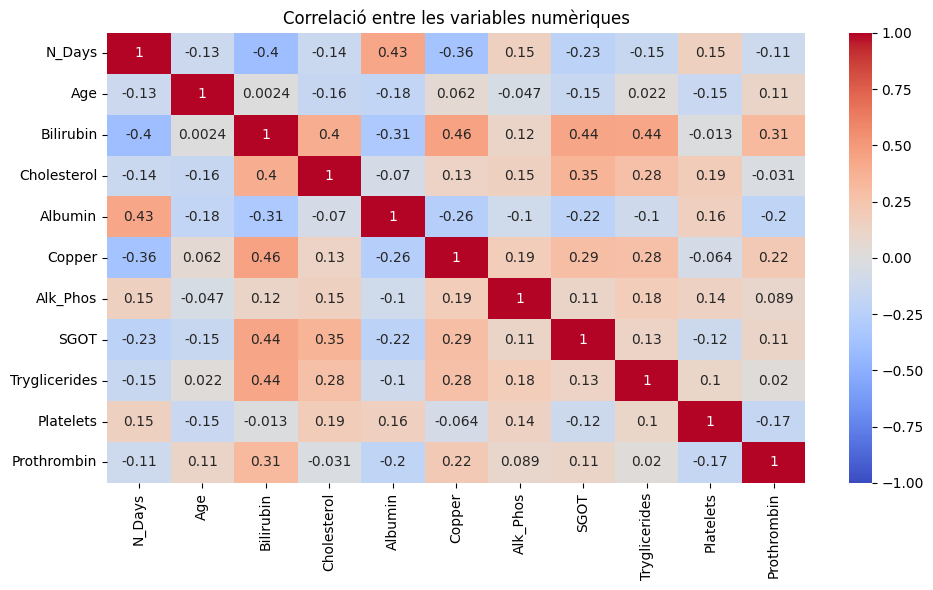

In [94]:
def numerical_vars_correlations(data: pd.DataFrame):
	"""
	Visualitza la correlació entre les variables numèriques.
	"""

	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

	plt.figure(figsize=(10, 6))

	sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

	plt.title('Correlació entre les variables numèriques')
	plt.tight_layout()
	plt.show()


numerical_vars_correlations(data=data)

### **Correlacions entre variables categòriques i variable objectiu**

In [ ]:
def categorical_target_relationships(data: pd.DataFrame):
    """
    Visualitza la relació entre les variables categòriques i la variable target.
    """
    categorical_columns = data.select_dtypes(include=['category']).columns.drop(['ID'])

    for col in categorical_columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=data, x=col, hue='Status')
        plt.title(f'Distribució de {col} vs Status (target)')
        plt.show()

categorical_target_relationships(data=train)

### **Anàlisis de Components Principals (ACP)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def principal_component_analysis(data: pd.DataFrame):
	"""
	Aplica PCA para explicar el 80% de la varianza y visualiza los resultados.

	:param X: DataFrame con los datos numéricos.
	:param categorical_columns: Lista de nombres de las columnas categóricas para análisis de centroides.
	"""
	# Seleccionar variables numéricas
	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns
	categorical_columns = data.select_dtypes(include=['category']).columns.drop(['ID'])

	# Aplicar PCA
	pca = PCA(n_components=0.80)
	X_pca = pca.fit_transform(data[numerical_columns])

	# Variància acumulada
	plt.figure(figsize=(10, 6))
	plt.plot(np.cumsum(pca.explained_variance_ratio_))
	plt.xlabel('Número de components')
	plt.ylabel('Variància acumulada')
	plt.title('Anàlisi de de la variància acumulada en funció del número de components')
	plt.grid(True)
	plt.show()

	# Gràfic de barres amb una línia que marca el 80% de la variància
	plt.figure(figsize=(10, 6))
	plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
	plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), c='red')
	plt.xlabel('Número de components')
	plt.ylabel('Variància')
	plt.title('Anàlisi de la variància en funció del número de components')
	plt.grid(True)
	plt.show()

	# Projecció de les variables numèriques
	plt.figure(figsize=(10, 6))
	plt.scatter(X_pca[:, 0], X_pca[:, 1])
	inercia_primer_comp = round(pca.explained_variance_ratio_[0] * 100, 2)
	inercia_segon_comp= round(pca.explained_variance_ratio_[1] * 100, 2)
	plt.xlabel(f'1r component principal ({inercia_primer_comp}%)')
	plt.ylabel(f'2n component principal ({inercia_segon_comp}%)')
	plt.title('Projecció de les variables numèriques sobre els dos primers components principals')
	plt.grid(True)

	# Projecció de les variables categòriques
	for col in categorical_columns:
		if col in data.columns:
			for category in np.unique(data[col]):
				mask = data[col] == category
				centroid = np.mean(X_pca[mask], axis=0)
				plt.scatter(centroid[0], centroid[1], marker='x', color='red')
	plt.legend()
	plt.show()

principal_component_analysis(data=train.dropna())

### **1r Model: K-Nearest Neighbors (KNN)**

In [125]:
def knn_prediction(X_train: pd.DataFrame, \
				   	y_train: pd.Series, \
					X_test: pd.DataFrame, \
					y_test: pd.Series, \
					k: int = 5):
	"""
	Realitza una predicció utilitzant l'algorisme KNN.
	"""
	from sklearn.neighbors import KNeighborsClassifier
	from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

	assert k > 0, "El paràmetre 'k' ha de ser major que 0."

	# Creem i entrenem el model
	knn = KNeighborsClassifier(n_neighbors=k)
	knn.fit(X_train, y_train)

	# Realitzem la predicció
	y_pred = knn.predict(X_test)

	# Mostrem els resultats
	scores = {
		'accuracy': accuracy_score(y_test, y_pred),
		'f1-micro': f1_score(y_test, y_pred, average='micro'),
		'f1-macro': f1_score(y_test, y_pred, average='macro'),
		'f1-weighted': f1_score(y_test, y_pred, average='weighted'),
		'precision-micro': precision_score(y_test, y_pred, average='micro'),
		'precision-macro': precision_score(y_test, y_pred, average='macro'),
		'precision-weighted': precision_score(y_test, y_pred, average='weighted'),
		'recall-micro': recall_score(y_test, y_pred, average='micro'),
		'recall-macro': recall_score(y_test, y_pred, average='macro'),
		'recall-weighted': recall_score(y_test, y_pred, average='weighted')
	}

	print(f"SCORES KNN (k={k}):")
	for metric in scores:
		print(f"\t*{metric} --> {scores[metric]}")

	# Matriu de confusió
	cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
	disp.plot()

	plt.title(f'Matriu de confusió de KNN (k={k})')
	plt.show()



### **2n Model: Decision Tree**

In [ ]:
def dt_prediction(X_train: pd.DataFrame, \
				  	y_train: pd.Series, \
					X_test: pd.DataFrame, \
					y_test: pd.Series, \
					criterion: str = 'gini', \
					random_state: int = 42):
	"""
	Realitza una predicció utilitzant l'algorisme Decision Tree.
	"""
	from sklearn.tree import DecisionTreeClassifier
	from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

	assert criterion in {'gini', 'entropy'}, "El paràmetre 'criterion' ha de ser 'gini' o 'entropy'."

	# Creem i entrenem el model
	dt = DecisionTreeClassifier(criterion=criterion, random_state=random_state)
	dt.fit(X_train, y_train)

	# Realitzem la predicció
	y_pred = dt.predict(X_test)

	# Mostrem els resultats
	scores = {
		'accuracy': accuracy_score(y_test, y_pred),
		'f1-micro': f1_score(y_test, y_pred, average='micro'),
		'f1-macro': f1_score(y_test, y_pred, average='macro'),
		'f1-weighted': f1_score(y_test, y_pred, average='weighted'),
		'precision-micro': precision_score(y_test, y_pred, average='micro'),
		'precision-macro': precision_score(y_test, y_pred, average='macro'),
		'precision-weighted': precision_score(y_test, y_pred, average='weighted'),
		'recall-micro': recall_score(y_test, y_pred, average='micro'),
		'recall-macro': recall_score(y_test, y_pred, average='macro'),
		'recall-weighted': recall_score(y_test, y_pred, average='weighted')
	}

	print(f"SCORES DECISION TREE (criterion={criterion}):")
	for metric in scores:
		print(f"\t*{metric} --> {scores[metric]}")

	# Matriu de confusió
	cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
	disp.plot()

	plt.title(f'Matriu de confusió de Decision Tree (criterion={criterion})')

### **3r Model: Support Vector Machine (SVM)**

In [ ]:
def svm_prediction(X_train: pd.DataFrame, \
				   	y_train: pd.Series, \
					X_test: pd.DataFrame, \
					y_test: pd.Series, \
					kernel: str = 'linear', \
					C: float = 1, gamma = 'scale', \
					random_state: int = 42):
	"""
	Realitza una predicció utilitzant l'algorisme Support Vector Machine.
	"""
	from sklearn.svm import SVC
	from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

	assert kernel in {'linear', 'poly', 'rbf', 'sigmoid'}, "El paràmetre 'kernel' ha de ser 'linear', 'poly', 'rbf' o 'sigmoid'."
	assert gamma in {'scale', 'auto'} or isinstance(gamma, float), "El paràmetre 'gamma' ha de ser 'scale', 'auto' o un valor numèric."
	assert C > 0, "El paràmetre 'C' ha de ser major que 0."

	# Creem i entrenem el model
	svm = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state)
	svm.fit(X_train, y_train)

	# Realitzem la predicció
	y_pred = svm.predict(X_test)

	# Mostrem els resultats
	scores = {
		'accuracy': accuracy_score(y_test, y_pred),
		'f1-micro': f1_score(y_test, y_pred, average='micro'),
		'f1-macro': f1_score(y_test, y_pred, average='macro'),
		'f1-weighted': f1_score(y_test, y_pred, average='weighted'),
		'precision-micro': precision_score(y_test, y_pred, average='micro'),
		'precision-macro': precision_score(y_test, y_pred, average='macro'),
		'precision-weighted': precision_score(y_test, y_pred, average='weighted'),
		'recall-micro': recall_score(y_test, y_pred, average='micro'),
		'recall-macro': recall_score(y_test, y_pred, average='macro'),
		'recall-weighted': recall_score(y_test, y_pred, average='weighted')
	}

	print(f"SCORES SVM (kernel={kernel}, C={C}, gamma={gamma}):")
	for metric in scores:
		print(f"\t*{metric} --> {scores[metric]}")

	# Matriu de confusió
	cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
	disp.plot()

	plt.title(f'Matriu de confusió de Support Vector Machine (kernel={kernel}, C={C}, gamma={gamma})')

### **Execució d'experiments**

In [ ]:
def run_experiment(
	delete_outliers: bool = False, \
	iqr_factor_outliers: int = 3, \
	delete_last_rows: bool = False, \
	test_size: float = 0.15, \
	random_state: int = 42, \
	scaler = 'minmax', \
	num_imputer = 'best', \
	cat_imputer = 'best', \
	num_metric_imputer = 'r2', \
	cat_metric_imputer = 'accuracy', \
	balance_method = 'smote', \
	predictor = 'knn', \
	k: int = 5, \
	criterion: str = 'gini', \
	kernel: str = 'linear', \
	C: float = 1, \
	gamma = 'scale', \
	"""
	Realitza un experiment complet amb els paràmetres especificats.
	"""


In [ ]:
def find_best_experiment(executions: int = 10):
	"""
	Prova totes les combinacions de paràmetres i retorna la millor.
	"""

	